# Correct NGI 2010 Little Karoo subset

This notebook works with the NGI imagery from the paper.  It uses a new MODIS NBAR reference to correct the subset of imagery that was used for testing the effect of the window size.  It then evaluates, comparing source, original corrected ('XCALIB') and corrected correlation with the SPOT-5 and a new Landsat-7 reference.  

## Setup

In [1]:
# matplotlib and gdal should be installed if they aren't already.
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge gdal matplotlib
# else:
#     # install into the conda environment the notebook is being run from
#     !{sys.executable} -m pip install gdal matplotlib

In [2]:
import sys
import logging
from pathlib import Path
from matplotlib import pyplot
import rasterio as rio
from tqdm.auto import tqdm
from rasterio.plot import show
import numpy as np
from homonim import RasterFuse, RasterCompare, Model

logging.basicConfig(level=logging.ERROR)

In [3]:
# create paths of source and reference images.
from glob import glob
src_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Source/'
    'WinExpSubset'
)
ref_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Reference/'
    'WinExpSubset'
)
src_paths = [
    Path(src_path) 
    for src_path in glob(str(src_root.joinpath('*_RGBN_CMP.tif')))
]
ref_path = ref_root.joinpath('MODIS-006-MCD43A4-2010_01_26_B1432.tif')

## Surface reflectance correction

Here, we fuse each aerial image with a MODIS NBAR reference using the `RasterFuse` class.  

In [4]:
from homonim import utils, Model, ProcCrs

# create corrected file names corresponding to source names
corr_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Corrected/'
    'WinExpSubset'
)

model = Model.gain
kernel_shape = (3, 3)
post_fix = utils.create_out_postfix(
    ProcCrs.ref, model=model, kernel_shape=kernel_shape, driver='GTiff'
)
corr_paths = [
    corr_root.joinpath(src_path.stem + post_fix)
    for src_path in src_paths
]

In [5]:
for src_path, corr_path in tqdm(
    zip(src_paths, corr_paths), desc='Total', unit='File', 
    total=len(src_paths), dynamic_ncols=True, 
):
    with RasterFuse(src_path, ref_path) as raster_fuse:
        print(f'{corr_path.name}:')
        raster_fuse.process(
            corr_path, model, kernel_shape, 
            block_config=dict(threads=2, max_block_mem=256), 
            out_profile=dict(dtype='uint16', nodata=0), 
            model_config=dict(mask_partial=False), 
            overwrite=True
        )
    # equivalent homonim command line:
    # !homonim fuse -m gain-blk-offset -k 1 1 -o {src_path} {ref_path}

Total:   0%|                                                                                  | 0/28 [00:00<?,…

## Visualisation

Next, we create a VRT mosaic of the corrected images to assist with visualisation and evaluation.

In [6]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_path = corr_root.joinpath(f'NGI_3321{post_fix[:-4]}.vrt')
ds = gdal.BuildVRT(
    str(corr_mosaic_path.absolute()), [str(cp) for cp in corr_paths]
)
ds.FlushCache()

orig_corr_mosaic_path = corr_root.joinpath(
    'Original/NGI_3321BD-3322AC_2010_LittleKaroo_WinExpSubset_Orig_Corrected.vrt'
)

src_mosaic_path = src_root.joinpath(    
    'NGI_3321BD-3322AC_2010_LittleKaroo_WinExpSubset_Source.vrt'
)

# SPOT 5 
cmp_ref_path = ref_root.joinpath(
    'SPOT5_oATCORCorrected_METADATA_00812098_AutoGCP_NgiFormat.tif'
)
# src and ref bands for comparing with SPOT5 reference
src_bands = [4, 1, 2]  
ref_bands = [1, 2, 3]

# Landsat-7
# cmp_ref_path = Path('LANDSAT-LE07-C02-T1_L2-LE07_173083_20100203_B3214.tif')
# src_bands = None
# ref_bands = None

Now we can display the source mosaic, reference image, original corrected, and corrected mosaic.

C:\Users\dugalh\.conda\envs\py310_geospatial\lib\site-packages\matplotlib\cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


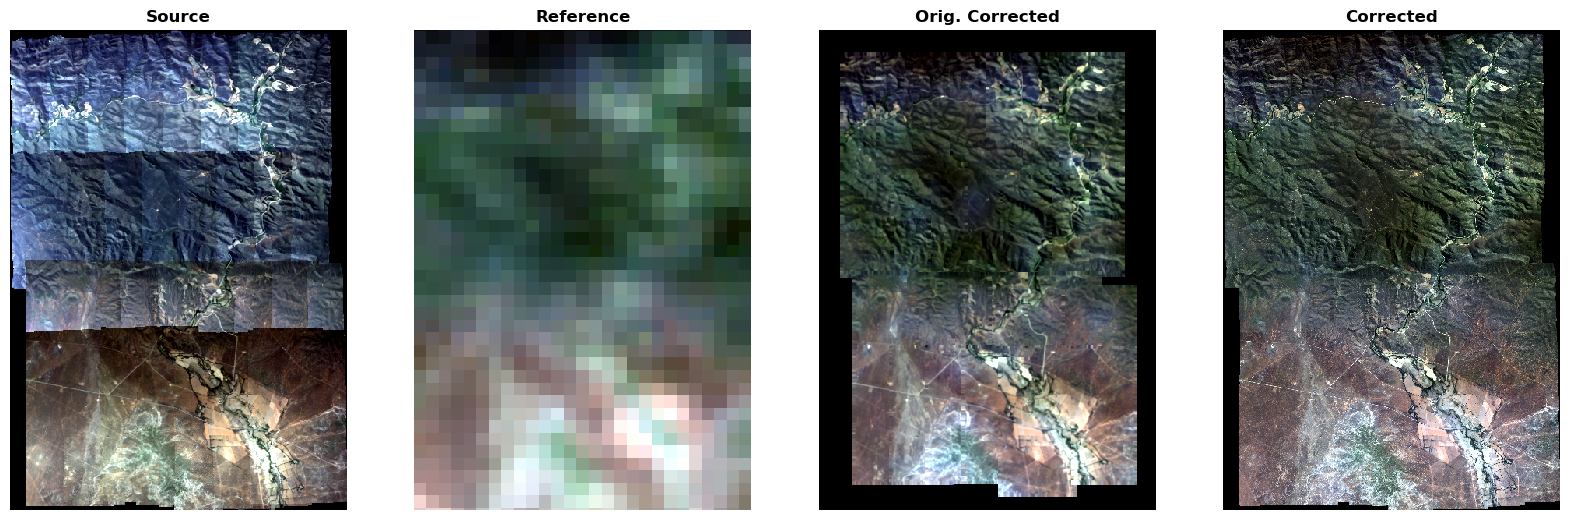

In [7]:
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
# VRT mosaic of the source files

fig, axes = pyplot.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 10))
indexes = [1, 2, 3]
src_crs = None

for im_file, ds_fact, ax, label in zip(
    [src_mosaic_path, ref_path, orig_corr_mosaic_path, corr_mosaic_path],
    [64, 1, 64, 64],
    axes,
    ['Source', 'Reference', 'Orig. Corrected', 'Corrected'], 
):
    # read, scale and display the image
    with rio.open(im_file, 'r') as ds:
        # reproject the ref to src crs
        src_crs = src_crs or ds.crs
        if ds.crs != src_crs:
            ds = WarpedVRT(ds, crs=src_crs, resampling=Resampling.bilinear)
        
        # read array with downsampling
        ds_shape = tuple(np.round(np.array(ds.shape) / ds_fact).astype('int'))
        transform = ds.transform * rio.Affine.scale(ds_fact)
        array = ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)

        # change nodata value to nan
        mask = np.any((array == ds.nodata) | np.isnan(array), axis=(0))
        array[:, mask] = np.nan

        # 'normalise' image 2%-98% -> 0-1
        for bi in range(array.shape[0]):
            array[bi] -= np.nanpercentile(array[bi], 1)
            array[bi] /= np.nanpercentile(array[bi], 99)
            array[bi] = np.clip(array[bi], 0, 1)

    ax = show(array[0:3], transform=transform, interpolation='nearest', ax=ax)

    ax.set_title(label, fontweight='bold')
    ax.axis('off')
    

# fig.savefig('../case_studies/basic_correction-src_ref_corr.png')

Note that the original corrected mosaic had the equivalent of `mask_partial=True` applied.  We haven't applied it here as it results in *nodata* through the middle of the mosaic where the two jobs meet.

## Evaluation

Finaly, we compare the *source*, *original corrected* and *corrected* similarity with a second (Landsat-7 / SPOT-5) *reference*.  

As a first step, we produce tables of comparison statistics with using the `RasterCompare` class.

In [8]:
# URL of the Landsat-8 reference
print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_mosaic_path, orig_corr_mosaic_path, corr_mosaic_path],
    ['Source', 'Orig. Corrected', 'Corrected'],
):
    with RasterCompare(
        im_path, cmp_ref_path, src_bands=src_bands, ref_bands=ref_bands,
    ) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        print(f'{im_label}:')
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

ABBREV   DESCRIPTION
-------- -----------------------------------------
r²       Pearson's correlation coefficient squared
RMSE     Root Mean Square Error
rRMSE    Relative RMSE (RMSE/mean(ref))
N        Number of pixels
Source:


  0%|                                                                                            |0/48 blocks …

Source comparison:

       Band    r²     RMSE   rRMSE       N
----------- ----- -------- ------- -------
Ref. band 1 0.601 1101.045   0.565 2538508
Ref. band 2 0.656  702.296   0.660 2538508
Ref. band 3 0.528  193.019   0.252 2538508
       Mean 0.595  665.453   0.492 2538508
Orig. Corrected:


  0%|                                                                                            |0/48 blocks …

Orig. Corrected comparison:

       Band    r²    RMSE   rRMSE       N
----------- ----- ------- ------- -------
Ref. band 1 0.897 229.299   0.116 2021300
Ref. band 2 0.919 162.688   0.152 2021300
Ref. band 3 0.906 138.358   0.180 2021300
       Mean 0.907 176.782   0.150 2021300
Corrected:


  0%|                                                                                            |0/48 blocks …

Corrected comparison:

       Band    r²    RMSE   rRMSE       N
----------- ----- ------- ------- -------
Ref. band 1 0.911 254.256   0.130 2538508
Ref. band 2 0.930 165.819   0.156 2538508
Ref. band 3 0.917 128.956   0.169 2538508
       Mean 0.919 183.011   0.152 2538508


There is a slight accuracy improvement over the original corrected mosaic, using *gain* model with a kernel shape of 3x3. I think this is due in part to a new MODIS NBAR reference which has not been reprojected/resampled as it was originally, and possibly due to an updated MODIS algorithm.  Also, in the original method, the MODIS reference would have been reprojected to the NGI CRS, while homonim keeps MODIS in its own CRS and grid, and reprojects NGI.  

Scatter plots are displayed next, using `RasterCompare` again, but this time to read spatially matching bands from the *source* / *original corrected* / *corrected* - *reference* pairs.  

In [9]:
from tqdm.auto import tqdm
count = 3
cmp_dict = {}

# loop over the source and corrected image files and corresponding axes etc
for im_i, im_path, im_label in zip(
    range(count),
    [src_mosaic_path, orig_corr_mosaic_path, corr_mosaic_path],
    ['Source', 'Orig. Corrected', 'Corrected'],
):
    cmp_dict[im_label] = dict(
        src=[[] for _ in range(count)], ref=[[] for _ in range(count)]
    )
    with RasterCompare(
        im_path, cmp_ref_path, src_bands=src_bands, ref_bands=ref_bands,
    ) as compare:
        # accumulate vectors of src and ref bands in ref CRSs
        for block_pair in tqdm(
            list(compare.block_pairs(max_block_mem=256)), 
            unit='block', desc=im_path.name, dynamic_ncols=True,
        ):
            src_ra, ref_ra = compare.read(block_pair)
            src_ra = src_ra.reproject(
                **ref_ra.proj_profile, resampling='average'
            )

            # vectors of valid pixels in the source/corrected and reference bands
            mask = src_ra.mask & ref_ra.mask  # mask of valid pixels
            cmp_dict[im_label]['ref'][block_pair.band_i] += src_ra.array[mask].tolist()
            cmp_dict[im_label]['src'][block_pair.band_i] += ref_ra.array[mask].tolist()


NGI_3321BD-3322AC_2010_LittleKaroo_WinExpSubset_Source.vrt:   0%|                            | 0/96 [00:00<?, …

NGI_3321BD-3322AC_2010_LittleKaroo_WinExpSubset_Orig_Corrected.vrt:   0%|                    | 0/96 [00:00<?, …

NGI_3321_FUSE_cREF_mGAIN_k3_3.vrt:   0%|                                                     | 0/96 [00:00<?, …

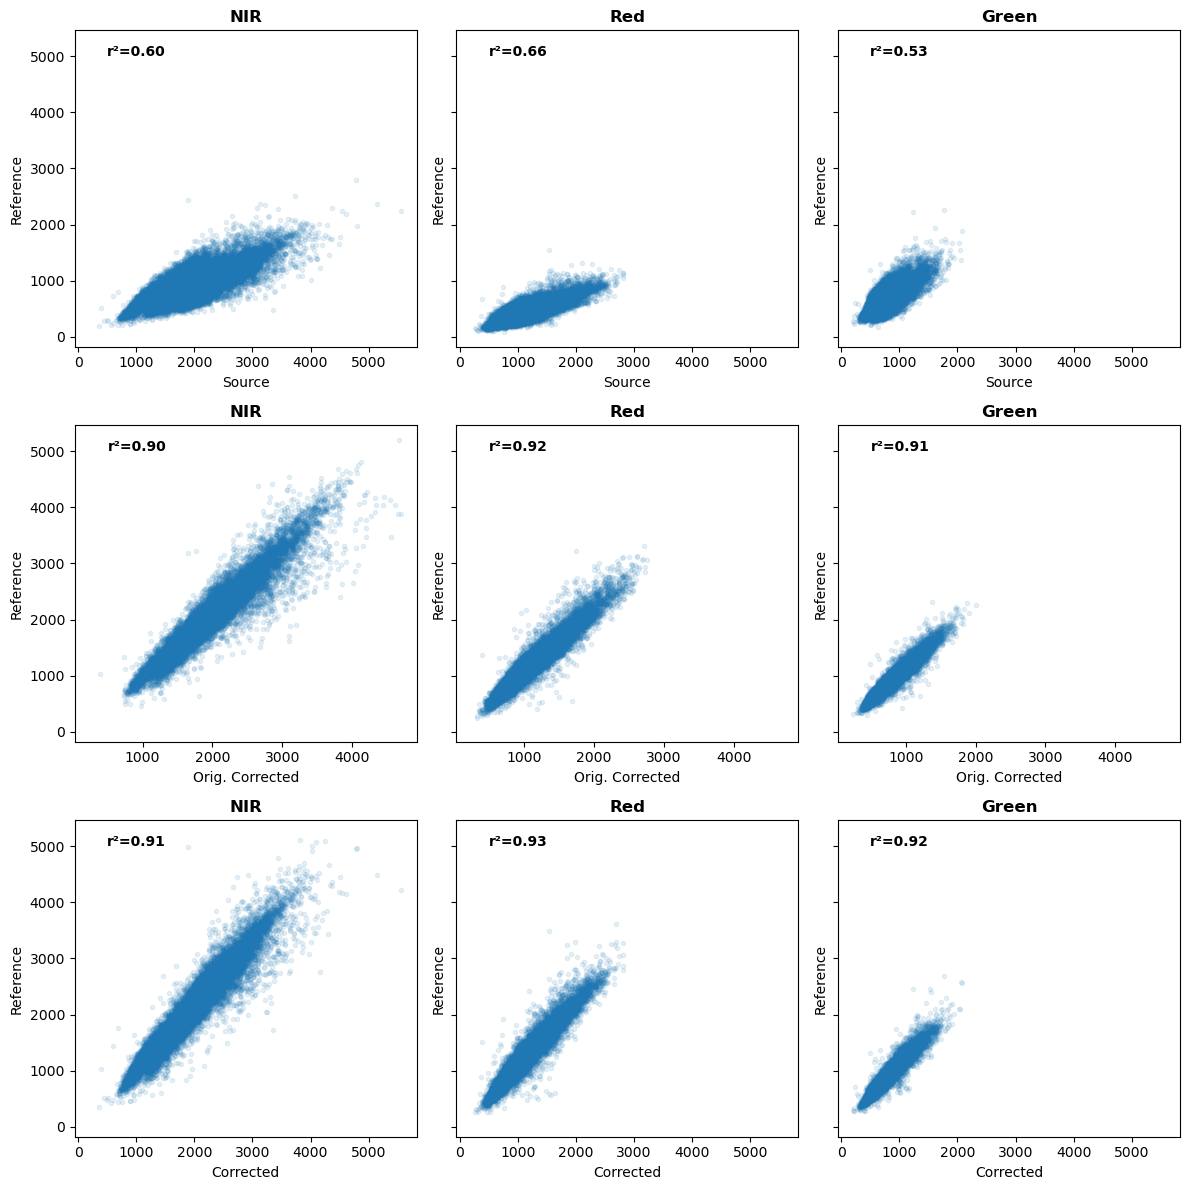

In [10]:
fig, axes = pyplot.subplots(3, count, figsize=(12, 12), sharex='row', sharey='all')

for im_i, im_label in zip(
    range(count),
    cmp_dict.keys(),
):
    # produce per-band scatter plots of source/corrected - reference 
    # surface reflectance 
    for band_i, src_v, ref_v, band_label in zip(
        range(count), 
        cmp_dict[im_label]['src'], 
        cmp_dict[im_label]['ref'], 
        # ['Red', 'Green', 'Blue', 'NIR']
         ['NIR', 'Red', 'Green']
    ):
        r2 = np.corrcoef(src_v, ref_v)[0, 1] ** 2 

        # create scatter plot
        axis = axes[im_i, band_i]
        axis.plot(src_v[::100], ref_v[::100], '.', alpha=0.1)
        # axis.text(500, 25000, f'r\N{SUPERSCRIPT TWO}={r2:.2f}', fontweight='bold')
        axis.text(500, 5000, f'r\N{SUPERSCRIPT TWO}={r2:.2f}', fontweight='bold')
        axis.set_xlabel(im_label)
        axis.set_ylabel('Reference')
        axis.set_title(band_label, fontweight='bold')
fig.tight_layout()
